<a href="https://colab.research.google.com/github/Valquire/EMBODYING/blob/main/predictive_model_MilNavalPlatform_endurance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Predictive Model of Military Naval Platform Endurance**
This notebook compiles and organizes the code generated for analyzing the endurance of an operational unit of the Brazilian Navy, using data collected from 2013 to 2017.

## **Setting Up the Environment: Installing and Importing Libraries**

In [1]:
!pip install -U kaleido

In [2]:
!pip install ImbalancedLearningRegression

In [3]:
# Importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import seaborn as sns
import numpy as np

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    GradientBoostingRegressor,
    RandomForestRegressor,
    VotingRegressor,
)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn import tree

from sklearn.model_selection import (
    train_test_split)

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# synthetic data
import ImbalancedLearningRegression as iblr

## **Integrate Historical Data from Military Naval Platform**

### **Loading Data**

In [4]:
# access to Google Drive
from google.colab import drive
drive.mount('/content/GoogleDrive')

Drive already mounted at /content/GoogleDrive; to attempt to forcibly remount, call drive.mount("/content/GoogleDrive", force_remount=True).


In [5]:
# load the SINGRA Dataset
df_Singra = pd.read_csv('/content/GoogleDrive/MyDrive/Projeto/Dados/SINGRA/RMC_MEIO1.csv',
                        sep=',', header=0, parse_dates=['PERIODO'],
                        dtype={'QTDE_ITENS_RM': np.float64, 'PRECO_UNITARIO_VENDA': np.float64})

In [6]:
# load the RFC Dataset
df_RFC = pd.read_csv('/content/GoogleDrive/MyDrive/Projeto/Dados/RFC/RFC.csv',
                        sep=',', header=0)#, dtype={'MILHAS': np.float64})


### **Data Exploration**

In [7]:
df_Singra.head(5)

,ANO,PERIODO,MES,SIGLA_OM,RM_TYPE,SITUACAO_RM,DESC_SITUACAO_RM,GRUPO_JURISDICAO,DESCRICAO_CLG,PI,NOME_PORTUGUES,UF,QTDE_ITENS_RM,PRECO_UNITARIO_VENDA
0,2013,2013-01-01,1,MEIO1,RMC,FN,FORNECIDA,COMBUSTIVEIS,ÓLEO DIESEL MARÍTIMO,190024045,ÓLEO DIESEL MARÍTIMO,LITRO,229000.0,NaN
1,2013,2013-01-01,1,MEIO1,RMC,FN,FORNECIDA,COMBUSTIVEIS,ÓLEO DIESEL MARÍTIMO,190024045,ÓLEO DIESEL MARÍTIMO,LITRO,230000.0,NaN
2,2013,2013-01-01,1,MEIO1,RMC,FN,FORNECIDA,COMBUSTIVEIS,ÓLEO DIESEL MARÍTIMO,190024045,ÓLEO DIESEL MARÍTIMO,LITRO,120000.0,NaN
3,2013,2013-02-01,2,MEIO1,RMC,FN,FORNECIDA,SUBSISTENCIA,* SEM TIPO CLG *,190010170,LOMBO EM PEDAÇOS,QUILOGRAMA,160.0,7.32
4,2013,2013-02-01,2,MEIO1,RMC,FN,FORNECIDA,SUBSISTENCIA,* SEM TIPO CLG *,190015262,GELÉIA,QUILOGRAMA,36.0,3.40


In [8]:
df_Singra.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1826 entries, 0 to 1825
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   ANO                   1826 non-null   int64         
 1   PERIODO               1826 non-null   datetime64[ns]
 2   MES                   1826 non-null   int64         
 3   SIGLA_OM              1826 non-null   object        
 4   RM_TYPE               1826 non-null   object        
 5   SITUACAO_RM           1826 non-null   object        
 6   DESC_SITUACAO_RM      1826 non-null   object        
 7   GRUPO_JURISDICAO      1826 non-null   object        
 8   DESCRICAO_CLG         1818 non-null   object        
 9   PI                    1826 non-null   object        
 10  NOME_PORTUGUES        1826 non-null   object        
 11  UF                    1826 non-null   object        
 12  QTDE_ITENS_RM         1826 non-null   float64       
 13  PRECO_UNITARIO_VEN

In [9]:
df_Singra['GRUPO_JURISDICAO'].value_counts()

GRUPO_JURISDICAO
SUBSISTENCIA    1478
COMBUSTIVEIS     348
Name: count, dtype: int64

In [10]:
# Remove consumable items outside the scope of work
df_Singra = df_Singra.drop(df_Singra.loc[lambda df_GENEROS: ((df_Singra.NOME_PORTUGUES == 'REFEIÇÃO INDIVIDUAL') |
                                                              (df_Singra.NOME_PORTUGUES == 'RAÇÃO DE SOBREVIVÊNCIA'))].index, axis=0)

In [11]:
# Standardization of the Supply Unit (SU)
print('UF antes:')
print(df_Singra['UF'].value_counts())
print('\n')

# 1 Pack of coffee = 0.5 kilogram
df_Singra['QTDE_ITENS_RM'] = df_Singra.apply(lambda x: x.QTDE_ITENS_RM*0.5 if x.UF == 'PACOTE'
                                             else x.QTDE_ITENS_RM, axis = 1)
# change the description
df_Singra['UF'] = df_Singra.UF.replace('PACOTE', 'QUILOGRAMA')

# 1 Bottle of vegetable oil = 0.9 liter
df_Singra['QTDE_ITENS_RM'] = df_Singra.apply(lambda x: x.QTDE_ITENS_RM*0.9 if x.UF == 'GARRAFA'
                                             else x.QTDE_ITENS_RM, axis = 1)
df_Singra['UF'] = df_Singra.UF.replace('GARRAFA', 'LITRO') # change the description

# 1 US Quarter Gallon of lubricant = 0.946353 liter
df_Singra['QTDE_ITENS_RM'] = df_Singra.apply(lambda x: x.QTDE_ITENS_RM*0.946353 if x.UF == 'QUARTO DE GALAO AMERICANO'
                                             else x.QTDE_ITENS_RM, axis = 1)
# 1 drum of lubricant = 200 liters
df_Singra['QTDE_ITENS_RM'] = df_Singra.apply(lambda x: x.QTDE_ITENS_RM*200 if x.UF == 'TAMBOR'
                                             else x.QTDE_ITENS_RM, axis = 1)

# 1 Gallon of lubricant = 3.785412 liters
df_Singra['QTDE_ITENS_RM'] = df_Singra.apply(lambda x: x.QTDE_ITENS_RM*3.785412 if x.UF == 'GALAO'
                                             else x.QTDE_ITENS_RM, axis = 1)

# 1 Bucket of lubricant = 20 liters
# 1 Bucket of grease = 20 kilograms
df_Singra['QTDE_ITENS_RM'] = df_Singra.apply(lambda x: x.QTDE_ITENS_RM*20 if x.UF == 'BALDE'
                                             else x.QTDE_ITENS_RM, axis = 1)
# 1 Can of grease = 5 kilograms
df_Singra['QTDE_ITENS_RM'] = df_Singra.apply(lambda x: x.QTDE_ITENS_RM*5 if x.UF == 'LATA'
                                             else x.QTDE_ITENS_RM, axis = 1)

# Change UF description for Lubricant and Grease
df_Singra['UF'] = df_Singra.apply(lambda x: 'LITRO' if x.DESCRICAO_CLG == 'LUBRIFICANTE'
                                  else 'QUILOGRAMA' if x.DESCRICAO_CLG == 'GRAXA' else x.UF, axis = 1)

print('UF depois:')
print(df_Singra['UF'].value_counts())

UF antes:
UF
QUILOGRAMA                   1247
LITRO                         421
BALDE                          58
TAMBOR                         49
GARRAFA                        35
GALAO                           6
QUARTO DE GALAO AMERICANO       3
PACOTE                          3
LATA                            1
Name: count, dtype: int64


UF depois:
UF
QUILOGRAMA    1260
LITRO          563
Name: count, dtype: int64


In [12]:
df_CLG = df_Singra.query('GRUPO_JURISDICAO == "COMBUSTIVEIS"')

In [13]:
df_CLG['DESCRICAO_CLG'].value_counts()

DESCRICAO_CLG
LUBRIFICANTE                   114
ÓLEO DIESEL MARÍTIMO            90
ÓLEO DIESEL ESPECIAL - OCMT     81
COMBUSTÍVEL AVIAÇÃO - QAV-5     34
GRAXA                           14
GASOLINA COMUM                   7
Name: count, dtype: int64

In [14]:
# Remove consumable items outside the scope of work
df_CLG = df_CLG.drop(df_CLG.loc[lambda df_CLG: ((df_CLG.DESCRICAO_CLG == 'COMBUSTÍVEL AVIAÇÃO - QAV-5')
                                                | (df_CLG.DESCRICAO_CLG == 'GASOLINA COMUM'))].index, axis=0)

In [15]:
df_CLG['DESCRICAO_CLG'].value_counts()

DESCRICAO_CLG
LUBRIFICANTE                   114
ÓLEO DIESEL MARÍTIMO            90
ÓLEO DIESEL ESPECIAL - OCMT     81
GRAXA                           14
Name: count, dtype: int64

In [16]:
# Standardization of the description of CLG types
df_CLG['DESCRICAO_CLG'] = df_CLG.DESCRICAO_CLG.replace('ÓLEO DIESEL ESPECIAL - OCMT', 'COMBUSTIVEL')
df_CLG['DESCRICAO_CLG'] = df_CLG.DESCRICAO_CLG.replace('ÓLEO DIESEL MARÍTIMO', 'COMBUSTIVEL')

In [17]:
df_CLG['DESCRICAO_CLG'].value_counts()

DESCRICAO_CLG
COMBUSTIVEL     171
LUBRIFICANTE    114
GRAXA            14
Name: count, dtype: int64

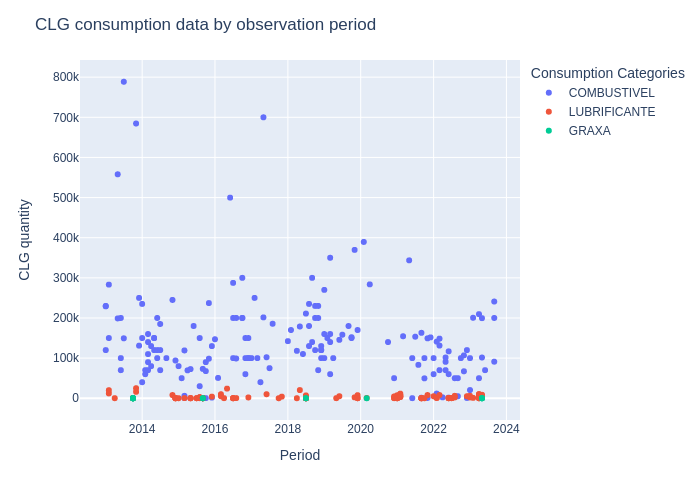

In [18]:
import warnings
warnings.simplefilter("ignore", category=FutureWarning)
# plotly code
fig1 = px.scatter(df_CLG, x = df_CLG.PERIODO,
                  y = df_CLG.QTDE_ITENS_RM,
                  color=df_CLG.DESCRICAO_CLG)
fig1.update_layout(
    title='CLG consumption data by observation period',
    xaxis_title='Period',
    yaxis_title='CLG quantity',
    legend_title='Consumption Categories',
)
fig1.show(renderer='png')

In [19]:
grupoCLG = df_CLG.groupby('DESCRICAO_CLG')
grupoCLG.first()

,ANO,PERIODO,MES,SIGLA_OM,RM_TYPE,SITUACAO_RM,DESC_SITUACAO_RM,GRUPO_JURISDICAO,PI,NOME_PORTUGUES,UF,QTDE_ITENS_RM,PRECO_UNITARIO_VENDA
DESCRICAO_CLG,,,,,,,,,,,,,
COMBUSTIVEL,2013,2013-01-01,1,MEIO1,RMC,FN,FORNECIDA,COMBUSTIVEIS,190024045,ÓLEO DIESEL MARÍTIMO,LITRO,229000.0,2.14
GRAXA,2013,2013-10-01,10,MEIO1,RMC,FN,FORNECIDA,COMBUSTIVEIS,190025257,GRAXA DE FINALIDADE GERAL,QUILOGRAMA,20.0,181.67
LUBRIFICANTE,2013,2013-02-01,2,MEIO1,RMC,FN,FORNECIDA,COMBUSTIVEIS,190035158,ÓLEO LUBRIFICANTE DE TURBINA DE VAPOR,LITRO,12000.0,1449.90


In [20]:
grupoCLG.get_group('COMBUSTIVEL')

,ANO,PERIODO,MES,SIGLA_OM,RM_TYPE,SITUACAO_RM,DESC_SITUACAO_RM,GRUPO_JURISDICAO,DESCRICAO_CLG,PI,NOME_PORTUGUES,UF,QTDE_ITENS_RM,PRECO_UNITARIO_VENDA
0,2013,2013-01-01,1,MEIO1,RMC,FN,FORNECIDA,COMBUSTIVEIS,COMBUSTIVEL,190024045,ÓLEO DIESEL MARÍTIMO,LITRO,229000.0,NaN
1,2013,2013-01-01,1,MEIO1,RMC,FN,FORNECIDA,COMBUSTIVEIS,COMBUSTIVEL,190024045,ÓLEO DIESEL MARÍTIMO,LITRO,230000.0,NaN
2,2013,2013-01-01,1,MEIO1,RMC,FN,FORNECIDA,COMBUSTIVEIS,COMBUSTIVEL,190024045,ÓLEO DIESEL MARÍTIMO,LITRO,120000.0,NaN
5,2013,2013-02-01,2,MEIO1,RMC,FN,FORNECIDA,COMBUSTIVEIS,COMBUSTIVEL,190024045,ÓLEO DIESEL COMBUSTÍVEL,LITRO,150000.0,2.14
20,2013,2013-02-01,2,MEIO1,RMC,FN,FORNECIDA,COMBUSTIVEIS,COMBUSTIVEL,190024044,ÓLEO DIESEL COMBUSTÍVEL,LITRO,283093.0,2.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1805,2023,2023-05-01,5,MEIO1,RMC,SNL,FORNECIDA SEM NL PATRIMONIAL,COMBUSTIVEIS,COMBUSTIVEL,190024045,ÓLEO DIESEL COMBUSTÍVEL,LITRO,101475.0,5.27
1816,2023,2023-06-01,6,MEIO1,RMC,SNL,FORNECIDA SEM NL PATRIMONIAL,COMBUSTIVEIS,COMBUSTIVEL,190024044,ÓLEO DIESEL COMBUSTÍVEL,LITRO,69983.0,8.14
1823,2023,2023-09-01,9,MEIO1,RMC,FN,FORNECIDA,COMBUSTIVEIS,COMBUSTIVEL,190024045,ÓLEO DIESEL MARÍTIMO,LITRO,200000.0,NaN
1824,2023,2023-09-01,9,MEIO1,RMC,FN,FORNECIDA,COMBUSTIVEIS,COMBUSTIVEL,190024045,ÓLEO DIESEL MARÍTIMO,LITRO,241000.0,NaN


In [21]:
# Method to transform groups into columns
pivot_df_CLG = df_CLG.pivot_table(values='QTDE_ITENS_RM', index='PERIODO', columns='DESCRICAO_CLG', aggfunc='sum')

# Display the resulting DataFrame
print(pivot_df_CLG)

DESCRICAO_CLG  COMBUSTIVEL  GRAXA  LUBRIFICANTE
PERIODO                                        
2013-01-01        579000.0    NaN           NaN
2013-02-01        433093.0    NaN       32000.0
2013-04-01             NaN    NaN         140.0
2013-05-01        756866.0    NaN           NaN
2013-06-01        370000.0    NaN           NaN
...                    ...    ...           ...
2023-02-01        200518.0    NaN        1000.0
2023-04-01        259520.0    NaN       29838.0
2023-05-01        300991.0   49.0       17600.0
2023-06-01         69983.0    NaN           NaN
2023-09-01        532070.0    NaN           NaN

[108 rows x 3 columns]


In [22]:
pivot_df_CLG.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 108 entries, 2013-01-01 to 2023-09-01
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   COMBUSTIVEL   95 non-null     float64
 1   GRAXA         5 non-null      float64
 2   LUBRIFICANTE  47 non-null     float64
dtypes: float64(3)
memory usage: 3.4 KB


In [23]:
df_GENEROS = df_Singra.query('GRUPO_JURISDICAO == "SUBSISTENCIA"')

In [24]:
df_GENEROS['NOME_PORTUGUES'].value_counts()

NOME_PORTUGUES
AÇÚCAR REFINADO                                   79
ÓLEO VEGETAL                                      77
ARROZ DESCASCADO                                  73
COXA DE FRANGO                                    70
LEITE INTEGRAL EM PÓ                              67
FEIJÕES PRETOS SECOS                              64
FILE PEITO FRANGO                                 63
GELÉIA                                            61
SUCO CAJU                                         56
MOLHO DE TOMATE                                   55
SAL DE MESA                                       54
FARINHA MANDIOCA                                  53
CAFÉ TORRADO                                      53
CREME DE LEITE                                    52
PATINHO ESPECIAL BOVINO                           47
AZEITE DE OLIVA                                   43
BIFE DO ALCATRA COM PICANHA BOVINO SEM OSSO       42
SUCO MARACUJA                                     42
LOMBO DESOSSADO                

Food Group, based on the Brazilian food pyramid (PHILIPPI et al., 1999)
The pyramid is made up of 8 food groups:

1.   Rice, bread, pasta, potatoes, cassava;
2.   Vegetables;
1.   Fruits;
2.   Meat and eggs;
1.   Milk, cheese and yogurt;
2.   Beans and oilseeds;
1.   Oils and fats;
2.   Sugars and sweets.









In [25]:
# 02 categories were included, DRINKS (tea, coffee, etc.) and SEASONING (pepper, salt, etc.)
# Even though they are not part of the food pyramid, there were records of consumption of these items
GRUPO_ALIMENTO = []

for i in df_GENEROS.itertuples():
  valor = i.NOME_PORTUGUES

  if valor == 'AÇÚCAR REFINADO':
    GRUPO_ALIMENTO.append('ACUCARES_DOCES')

  elif valor == 'ÓLEO VEGETAL':
    GRUPO_ALIMENTO.append('OLEOS_GORDURAS')

  elif valor == 'ARROZ DESCASCADO':
    GRUPO_ALIMENTO.append('ARROZ_MASSA_BATATA')

  elif valor == 'COXA DE FRANGO':
    GRUPO_ALIMENTO.append('CARNES_OVOS')

  elif valor == 'LEITE INTEGRAL EM PÓ':
    GRUPO_ALIMENTO.append('LEITE_QUEIJO')

  elif valor == 'FEIJÕES PRETOS SECOS':
    GRUPO_ALIMENTO.append('FEIJOES_OLEAGINOSAS')

  elif valor == 'FILE PEITO FRANGO':
    GRUPO_ALIMENTO.append('CARNES_OVOS')

  elif valor == 'GELÉIA':
    GRUPO_ALIMENTO.append('ACUCARES_DOCES')

  elif valor == 'SUCO CAJU':
    GRUPO_ALIMENTO.append('FRUTAS')

  elif valor == 'MOLHO DE TOMATE':
    GRUPO_ALIMENTO.append('LEGUMES_VERDURAS')

  elif valor == 'FARINHA MANDIOCA':
    GRUPO_ALIMENTO.append('ARROZ_MASSA_BATATA')

  elif valor == 'CREME DE LEITE':
    GRUPO_ALIMENTO.append('LEITE_QUEIJO')

  elif valor == 'PATINHO ESPECIAL BOVINO':
    GRUPO_ALIMENTO.append('CARNES_OVOS')

  elif valor == 'AZEITE DE OLIVA':
    GRUPO_ALIMENTO.append('OLEOS_GORDURAS')

  elif valor == 'BIFE DO ALCATRA COM PICANHA BOVINO SEM OSSO':
    GRUPO_ALIMENTO.append('CARNES_OVOS')

  elif valor == 'SUCO MARACUJA':
    GRUPO_ALIMENTO.append('FRUTAS')

  elif valor == 'LOMBO DESOSSADO':
    GRUPO_ALIMENTO.append('CARNES_OVOS')

  elif valor == 'ESPAGUETE':
    GRUPO_ALIMENTO.append('ARROZ_MASSA_BATATA')

  elif valor == 'BISCOITO CRACKER DE TRIGO':
    GRUPO_ALIMENTO.append('ARROZ_MASSA_BATATA')

  elif valor == 'LOMBO EM PEDAÇOS':
    GRUPO_ALIMENTO.append('CARNES_OVOS')

  elif valor == 'BISCOITO DE AÇÚCAR':
    GRUPO_ALIMENTO.append('ARROZ_MASSA_BATATA')

  elif valor == 'CHÃ DESOSSADO SEM MÚSCULO OU PONTA BOVINO':
    GRUPO_ALIMENTO.append('CARNES_OVOS')

  elif valor == 'MACARRÃO':
    GRUPO_ALIMENTO.append('CARNES_OVOS')

  elif valor == 'CACAU EM PÓ PARA BEBIDA':
    GRUPO_ALIMENTO.append('ACUCARES_DOCES')

  elif valor == 'PERNIL DESOSSADO E AMARRADO':
    GRUPO_ALIMENTO.append('CARNES_OVOS')

  elif valor == 'BIFE DE CONTRA-FILÉ DO LOMBO BOVINO DESOSSADO':
    GRUPO_ALIMENTO.append('CARNES_OVOS')

  elif valor == 'FILÉ MIGNON COMPLETO DE CARNE BOVINA':
    GRUPO_ALIMENTO.append('CARNES_OVOS')

  elif valor == 'FILEZINHO PEITO FRANGO':
    GRUPO_ALIMENTO.append('CARNES_OVOS')

  elif valor == 'ACÉM BOVINO':
    GRUPO_ALIMENTO.append('CARNES_OVOS')

  elif valor == 'BIFES DE CARNE BOVINA':
    GRUPO_ALIMENTO.append('CARNES_OVOS')

  elif valor == 'BIFE DE FILÉ DE CARNE BOVINA SEM OSSO ESPECIAL':
    GRUPO_ALIMENTO.append('CARNES_OVOS')

  elif valor == 'SUCO DE UVA ENLATADO':
    GRUPO_ALIMENTO.append('FRUTAS')

  elif valor == 'FEIJÃO-PINTO SECO':
    GRUPO_ALIMENTO.append('FEIJOES_OLEAGINOSAS')

  elif valor == 'ARROZ PARBOILIZADO':
    GRUPO_ALIMENTO.append('ARROZ_MASSA_BATATA')

  elif valor == 'BIFE BOVINO EM CUBOS ESPECIAL':
    GRUPO_ALIMENTO.append('CARNES_OVOS')

  elif valor == 'BEBIDA COM SABOR DE FRUTA':
    GRUPO_ALIMENTO.append('FRUTAS')

  elif valor == 'ARROZ MARROM':
    GRUPO_ALIMENTO.append('ARROZ_MASSA_BATATA')

  elif valor == 'CAFÉ TORRADO':
    GRUPO_ALIMENTO.append('BEBIDAS')

  else:
    GRUPO_ALIMENTO.append('TEMPEROS')

# Add Food Group column
df_GENEROS.insert(14, 'GRUPO_ALIMENTO', GRUPO_ALIMENTO)

df_GENEROS.head()

,ANO,PERIODO,MES,SIGLA_OM,RM_TYPE,SITUACAO_RM,DESC_SITUACAO_RM,GRUPO_JURISDICAO,DESCRICAO_CLG,PI,NOME_PORTUGUES,UF,QTDE_ITENS_RM,PRECO_UNITARIO_VENDA,GRUPO_ALIMENTO
3,2013,2013-02-01,2,MEIO1,RMC,FN,FORNECIDA,SUBSISTENCIA,* SEM TIPO CLG *,190010170,LOMBO EM PEDAÇOS,QUILOGRAMA,160.00,7.32,CARNES_OVOS
4,2013,2013-02-01,2,MEIO1,RMC,FN,FORNECIDA,SUBSISTENCIA,* SEM TIPO CLG *,190015262,GELÉIA,QUILOGRAMA,36.00,3.40,ACUCARES_DOCES
7,2013,2013-02-01,2,MEIO1,RMC,FN,FORNECIDA,SUBSISTENCIA,* SEM TIPO CLG *,190008021,ESPAGUETE,QUILOGRAMA,100.00,1.75,ARROZ_MASSA_BATATA
8,2013,2013-02-01,2,MEIO1,RMC,FN,FORNECIDA,SUBSISTENCIA,* SEM TIPO CLG *,190010176,LOMBO DESOSSADO,QUILOGRAMA,151.98,9.49,CARNES_OVOS
9,2013,2013-02-01,2,MEIO1,RMC,FN,FORNECIDA,SUBSISTENCIA,* SEM TIPO CLG *,190007993,LEITE INTEGRAL EM PÓ,QUILOGRAMA,104.00,9.95,LEITE_QUEIJO


In [26]:
df_GENEROS['GRUPO_ALIMENTO'].value_counts()

GRUPO_ALIMENTO
CARNES_OVOS            485
ARROZ_MASSA_BATATA     246
ACUCARES_DOCES         164
OLEOS_GORDURAS         120
LEITE_QUEIJO           119
FRUTAS                 109
FEIJOES_OLEAGINOSAS     68
TEMPEROS                56
LEGUMES_VERDURAS        55
BEBIDAS                 53
Name: count, dtype: int64

In [27]:
fig1 = px.scatter(df_GENEROS, x = df_GENEROS.PERIODO,
                  y = df_GENEROS.QTDE_ITENS_RM,
                  color=df_GENEROS.GRUPO_ALIMENTO)
fig1.update_layout(
    title='Food consumption data per observation period',
    xaxis_title='Period',
    yaxis_title='Quantity of Food',
    legend_title='Consumption Categories',
)
fig1.show()

In [28]:
# Method to transform groups into columns
pivot_df_GENEROS = df_GENEROS.pivot_table(values='QTDE_ITENS_RM', index='PERIODO', columns='GRUPO_ALIMENTO', aggfunc='sum')

# Display the resulting DataFrame
print(pivot_df_GENEROS)

GRUPO_ALIMENTO  ACUCARES_DOCES  ARROZ_MASSA_BATATA  BEBIDAS  CARNES_OVOS  \
PERIODO                                                                    
2013-02-01               90.00               330.0      NaN     1642.203   
2013-03-01              150.00               626.0      NaN     1846.950   
2013-04-01              759.40               943.6    120.0     1662.200   
2013-05-01              308.00               838.4      NaN     3151.660   
2013-06-01               35.64               100.0    100.0      208.910   
...                        ...                 ...      ...          ...   
2023-02-01                 NaN               200.0      NaN     1583.450   
2023-03-01              595.04               840.0      NaN     3099.070   
2023-04-01              250.00               400.0    160.0     2857.953   
2023-05-01              524.74               616.0      NaN     2168.895   
2023-06-01                 NaN               590.0      NaN     2263.140   

GRUPO_ALIME

In [29]:
pivot_df_GENEROS.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 98 entries, 2013-02-01 to 2023-06-01
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ACUCARES_DOCES       87 non-null     float64
 1   ARROZ_MASSA_BATATA   86 non-null     float64
 2   BEBIDAS              51 non-null     float64
 3   CARNES_OVOS          91 non-null     float64
 4   FEIJOES_OLEAGINOSAS  63 non-null     float64
 5   FRUTAS               62 non-null     float64
 6   LEGUMES_VERDURAS     55 non-null     float64
 7   LEITE_QUEIJO         79 non-null     float64
 8   OLEOS_GORDURAS       74 non-null     float64
 9   TEMPEROS             54 non-null     float64
dtypes: float64(10)
memory usage: 8.4 KB


In [30]:
grupoGENEROS = df_GENEROS.groupby('GRUPO_ALIMENTO')
grupoGENEROS.first()

,ANO,PERIODO,MES,SIGLA_OM,RM_TYPE,SITUACAO_RM,DESC_SITUACAO_RM,GRUPO_JURISDICAO,DESCRICAO_CLG,PI,NOME_PORTUGUES,UF,QTDE_ITENS_RM,PRECO_UNITARIO_VENDA
GRUPO_ALIMENTO,,,,,,,,,,,,,,
ACUCARES_DOCES,2013,2013-02-01,2,MEIO1,RMC,FN,FORNECIDA,SUBSISTENCIA,* SEM TIPO CLG *,190015262,GELÉIA,QUILOGRAMA,36.00,3.40
ARROZ_MASSA_BATATA,2013,2013-02-01,2,MEIO1,RMC,FN,FORNECIDA,SUBSISTENCIA,* SEM TIPO CLG *,190008021,ESPAGUETE,QUILOGRAMA,100.00,1.75
BEBIDAS,2013,2013-04-01,4,MEIO1,RMC,FN,FORNECIDA,SUBSISTENCIA,* SEM TIPO CLG *,190032164,CAFÉ TORRADO,QUILOGRAMA,20.00,12.43
CARNES_OVOS,2013,2013-02-01,2,MEIO1,RMC,FN,FORNECIDA,SUBSISTENCIA,* SEM TIPO CLG *,190010170,LOMBO EM PEDAÇOS,QUILOGRAMA,160.00,7.32
FEIJOES_OLEAGINOSAS,2013,2013-02-01,2,MEIO1,RMC,FN,FORNECIDA,SUBSISTENCIA,* SEM TIPO CLG *,190009728,FEIJÕES PRETOS SECOS,QUILOGRAMA,120.00,2.84
FRUTAS,2013,2013-03-01,3,MEIO1,RMC,FN,FORNECIDA,SUBSISTENCIA,* SEM TIPO CLG *,190015050,SUCO CAJU,LITRO,120.00,4.67
LEGUMES_VERDURAS,2013,2013-03-01,3,MEIO1,RMC,FN,FORNECIDA,SUBSISTENCIA,* SEM TIPO CLG *,190015107,MOLHO DE TOMATE,QUILOGRAMA,21.76,2.10
LEITE_QUEIJO,2013,2013-02-01,2,MEIO1,RMC,FN,FORNECIDA,SUBSISTENCIA,* SEM TIPO CLG *,190007993,LEITE INTEGRAL EM PÓ,QUILOGRAMA,104.00,9.95
OLEOS_GORDURAS,2013,2013-03-01,3,MEIO1,RMC,FN,FORNECIDA,SUBSISTENCIA,* SEM TIPO CLG *,190008110,ÓLEO VEGETAL,LITRO,54.00,3.34


In [31]:
grupoGENEROS.get_group('FRUTAS')

,ANO,PERIODO,MES,SIGLA_OM,RM_TYPE,SITUACAO_RM,DESC_SITUACAO_RM,GRUPO_JURISDICAO,DESCRICAO_CLG,PI,NOME_PORTUGUES,UF,QTDE_ITENS_RM,PRECO_UNITARIO_VENDA,GRUPO_ALIMENTO
31,2013,2013-03-01,3,MEIO1,RMC,FN,FORNECIDA,SUBSISTENCIA,* SEM TIPO CLG *,190015050,SUCO CAJU,LITRO,120.0,4.67,FRUTAS
32,2013,2013-03-01,3,MEIO1,RMC,FN,FORNECIDA,SUBSISTENCIA,* SEM TIPO CLG *,190015044,SUCO MARACUJA,LITRO,120.0,2.44,FRUTAS
50,2013,2013-04-01,4,MEIO1,RMC,FN,FORNECIDA,SUBSISTENCIA,* SEM TIPO CLG *,190015050,SUCO CAJU,LITRO,60.0,4.67,FRUTAS
81,2013,2013-05-01,5,MEIO1,RMC,FN,FORNECIDA,SUBSISTENCIA,* SEM TIPO CLG *,190015050,SUCO CAJU,LITRO,150.0,4.67,FRUTAS
86,2013,2013-05-01,5,MEIO1,RMC,FN,FORNECIDA,SUBSISTENCIA,* SEM TIPO CLG *,190015050,SUCO CAJU,LITRO,84.0,2.88,FRUTAS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1757,2023,2023-04-01,4,MEIO1,RMC,FN,FORNECIDA,SUBSISTENCIA,* SEM TIPO CLG *,190015061,SUCO DE UVA ENLATADO,LITRO,120.0,5.31,FRUTAS
1763,2023,2023-04-01,4,MEIO1,RMC,FN,FORNECIDA,SUBSISTENCIA,* SEM TIPO CLG *,190015050,SUCO CAJU,LITRO,120.0,3.19,FRUTAS
1783,2023,2023-05-01,5,MEIO1,RMC,FN,FORNECIDA,SUBSISTENCIA,* SEM TIPO CLG *,190015050,SUCO CAJU,LITRO,168.0,3.19,FRUTAS
1800,2023,2023-05-01,5,MEIO1,RMC,SNL,FORNECIDA SEM NL PATRIMONIAL,SUBSISTENCIA,* SEM TIPO CLG *,190015044,SUCO MARACUJA,LITRO,120.0,8.10,FRUTAS


In [32]:
# Concatenates the CLG and GENEROS dataframes
df_Singra_T = pd.concat([pivot_df_CLG, pivot_df_GENEROS], axis=1)
# Impute the mean for unknown values
df_Singra_T = df_Singra_T.fillna(df_Singra_T.mean())

In [33]:
df_Singra_T.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 125 entries, 2013-01-01 to 2023-09-01
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   COMBUSTIVEL          125 non-null    float64
 1   GRAXA                125 non-null    float64
 2   LUBRIFICANTE         125 non-null    float64
 3   ACUCARES_DOCES       125 non-null    float64
 4   ARROZ_MASSA_BATATA   125 non-null    float64
 5   BEBIDAS              125 non-null    float64
 6   CARNES_OVOS          125 non-null    float64
 7   FEIJOES_OLEAGINOSAS  125 non-null    float64
 8   FRUTAS               125 non-null    float64
 9   LEGUMES_VERDURAS     125 non-null    float64
 10  LEITE_QUEIJO         125 non-null    float64
 11  OLEOS_GORDURAS       125 non-null    float64
 12  TEMPEROS             125 non-null    float64
dtypes: float64(13)
memory usage: 13.7 KB


In [34]:
df_Singra_T.head()

,COMBUSTIVEL,GRAXA,LUBRIFICANTE,ACUCARES_DOCES,ARROZ_MASSA_BATATA,BEBIDAS,CARNES_OVOS,FEIJOES_OLEAGINOSAS,FRUTAS,LEGUMES_VERDURAS,LEITE_QUEIJO,OLEOS_GORDURAS,TEMPEROS
PERIODO,,,,,,,,,,,,,
2013-01-01,579000.000000,75.6,7504.373609,339.076552,573.195349,76.27451,1864.602824,286.190476,245.258065,111.867636,186.931646,207.162162,84.777778
2013-02-01,433093.000000,75.6,32000.000000,90.000000,330.000000,76.27451,1642.203000,120.000000,245.258065,111.867636,104.000000,207.162162,60.000000
2013-03-01,262525.589474,75.6,7504.373609,150.000000,626.000000,76.27451,1846.950000,286.190476,240.000000,21.760000,186.931646,54.000000,30.000000
2013-04-01,262525.589474,75.6,140.000000,759.400000,943.600000,120.00000,1662.200000,210.000000,60.000000,111.867636,150.000000,284.000000,60.000000
2013-05-01,756866.000000,75.6,7504.373609,308.000000,838.400000,76.27451,3151.660000,300.000000,318.000000,111.867636,351.200000,410.000000,114.000000


In [35]:
# Includes the PERIOD index as a dataframe column
df_Singra_T = df_Singra_T.rename_axis('PERIODO').reset_index()

In [36]:
df_Singra_T.head()

,PERIODO,COMBUSTIVEL,GRAXA,LUBRIFICANTE,ACUCARES_DOCES,ARROZ_MASSA_BATATA,BEBIDAS,CARNES_OVOS,FEIJOES_OLEAGINOSAS,FRUTAS,LEGUMES_VERDURAS,LEITE_QUEIJO,OLEOS_GORDURAS,TEMPEROS
0,2013-01-01,579000.000000,75.6,7504.373609,339.076552,573.195349,76.27451,1864.602824,286.190476,245.258065,111.867636,186.931646,207.162162,84.777778
1,2013-02-01,433093.000000,75.6,32000.000000,90.000000,330.000000,76.27451,1642.203000,120.000000,245.258065,111.867636,104.000000,207.162162,60.000000
2,2013-03-01,262525.589474,75.6,7504.373609,150.000000,626.000000,76.27451,1846.950000,286.190476,240.000000,21.760000,186.931646,54.000000,30.000000
3,2013-04-01,262525.589474,75.6,140.000000,759.400000,943.600000,120.00000,1662.200000,210.000000,60.000000,111.867636,150.000000,284.000000,60.000000
4,2013-05-01,756866.000000,75.6,7504.373609,308.000000,838.400000,76.27451,3151.660000,300.000000,318.000000,111.867636,351.200000,410.000000,114.000000


In [37]:
df_Singra_T.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   PERIODO              125 non-null    datetime64[ns]
 1   COMBUSTIVEL          125 non-null    float64       
 2   GRAXA                125 non-null    float64       
 3   LUBRIFICANTE         125 non-null    float64       
 4   ACUCARES_DOCES       125 non-null    float64       
 5   ARROZ_MASSA_BATATA   125 non-null    float64       
 6   BEBIDAS              125 non-null    float64       
 7   CARNES_OVOS          125 non-null    float64       
 8   FEIJOES_OLEAGINOSAS  125 non-null    float64       
 9   FRUTAS               125 non-null    float64       
 10  LEGUMES_VERDURAS     125 non-null    float64       
 11  LEITE_QUEIJO         125 non-null    float64       
 12  OLEOS_GORDURAS       125 non-null    float64       
 13  TEMPEROS             125 non-null  

In [38]:
# Add the ANO column
ano = []
for i in df_Singra_T.itertuples():
  ano.append(i.PERIODO.year)

df_Singra_T.insert(loc=1, column='ANO', value=ano)

In [39]:
# Add the TRIMESTRE column
trimestre =[]
for i in df_Singra_T.itertuples():
  if i.PERIODO.month <= 3:
    trimestre.append(1)
  elif i.PERIODO.month <= 6:
    trimestre.append(2)
  elif i.PERIODO.month <= 9:
    trimestre.append(3)
  else:
    trimestre.append(4)

df_Singra_T.insert(loc=2, column='TRIMESTRE', value=trimestre)

In [40]:
df_Singra_T.head(10)

,PERIODO,ANO,TRIMESTRE,COMBUSTIVEL,GRAXA,LUBRIFICANTE,ACUCARES_DOCES,ARROZ_MASSA_BATATA,BEBIDAS,CARNES_OVOS,FEIJOES_OLEAGINOSAS,FRUTAS,LEGUMES_VERDURAS,LEITE_QUEIJO,OLEOS_GORDURAS,TEMPEROS
0,2013-01-01,2013,1,579000.000000,75.6,7504.373609,339.076552,573.195349,76.27451,1864.602824,286.190476,245.258065,111.867636,186.931646,207.162162,84.777778
1,2013-02-01,2013,1,433093.000000,75.6,32000.000000,90.000000,330.000000,76.27451,1642.203000,120.000000,245.258065,111.867636,104.000000,207.162162,60.000000
2,2013-03-01,2013,1,262525.589474,75.6,7504.373609,150.000000,626.000000,76.27451,1846.950000,286.190476,240.000000,21.760000,186.931646,54.000000,30.000000
3,2013-04-01,2013,2,262525.589474,75.6,140.000000,759.400000,943.600000,120.00000,1662.200000,210.000000,60.000000,111.867636,150.000000,284.000000,60.000000
4,2013-05-01,2013,2,756866.000000,75.6,7504.373609,308.000000,838.400000,76.27451,3151.660000,300.000000,318.000000,111.867636,351.200000,410.000000,114.000000
5,2013-06-01,2013,2,370000.000000,75.6,7504.373609,35.640000,100.000000,100.00000,208.910000,286.190476,180.000000,111.867636,186.931646,207.162162,24.000000
6,2013-07-01,2013,3,937915.000000,75.6,7504.373609,253.460000,510.000000,76.27451,971.461000,180.000000,120.000000,54.400000,100.000000,158.000000,84.777778
7,2013-08-01,2013,3,262525.589474,75.6,7504.373609,434.000000,646.000000,50.00000,1148.200000,90.000000,636.000000,56.000000,100.000000,374.000000,60.000000
8,2013-09-01,2013,3,262525.589474,75.6,7504.373609,23.760000,250.000000,50.00000,607.100000,286.190476,245.258065,111.867636,130.200000,207.162162,30.000000
9,2013-10-01,2013,4,262525.589474,151.0,1360.000000,197.520000,300.000000,50.00000,350.600000,180.000000,245.258065,84.000000,100.000000,208.000000,84.777778


In [41]:
# Sums values ​​based on ANO and TRIMESTRE
df_SINGRA_TRIM = df_Singra_T.groupby(['ANO', 'TRIMESTRE'])[['COMBUSTIVEL', 'GRAXA',	'LUBRIFICANTE',	'ACUCARES_DOCES',	'ARROZ_MASSA_BATATA',	'BEBIDAS',	'CARNES_OVOS',	'FEIJOES_OLEAGINOSAS',	'FRUTAS',	'LEGUMES_VERDURAS',	'LEITE_QUEIJO',	'OLEOS_GORDURAS',	'TEMPEROS']].sum()
df_SINGRA_TRIM.head()

COMBUSTIVEL  GRAXA  LUBRIFICANTE  ACUCARES_DOCES  \
ANO  TRIMESTRE                                                      
2013 1          1.274619e+06  226.8  47008.747218      579.076552   
     2          1.389392e+06  226.8  15148.747218     1103.040000   
     3          1.462966e+06  226.8  22513.120827      711.220000   
     4          1.328019e+06  302.2  49864.373609     1276.596552   
2014 1          1.125000e+06  226.8  22513.120827     1017.229655   

                ARROZ_MASSA_BATATA     BEBIDAS  CARNES_OVOS  \
ANO  TRIMESTRE                                                
2013 1                 1529.195349  228.823529  5353.755824   
     2                 1882.000000  296.274510  5022.770000   
     3                 1406.000000  176.274510  2726.761000   
     4                 2620.000000  226.274510  5423.980000   
2014 1                 1719.586047  228.823529  5593.808473   

                FEIJOES_OLEAGINOSAS       FRUTAS  LEGUMES_VERDURAS  \
ANO  TRIMESTRE                                                       
2013 1                   692.380952   730.516129        245.495273   
     2                   796.190476   558.000000        335.602909   
     3                   556.190476  1001.258065        222.267636   
     4                  1576.190476   688.516129        223.867636   
2014 1                   858.571429   735.774194        335.602909   

                LEITE_QUEIJO  OLEOS_GORDURAS    TEMPEROS  
ANO  TRIMESTRE                                            
2013 1            477.863291      468.324324  174.777778  
     2            688.131646      901.162162  198.000000  
     3            330.200000      739.162162  174.777778  
     4            389.531646      760.000000  289.555556  
2014 1            560.794937      621.486486  254.333333

In [42]:
df_RFC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175 entries, 0 to 174
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   TV                    155 non-null    float64
 1   DT_INICIO             155 non-null    object 
 2   DT_FIM                155 non-null    object 
 3   OPERACAO              155 non-null    object 
 4   ANO                   20 non-null     float64
 5   TRIMESTRE             20 non-null     float64
 6   MILITARES             175 non-null    int64  
 7   DIAS_PORTO_SEDE       21 non-null     float64
 8   DIAS_PORTO_FORA_SEDE  114 non-null    float64
 9   MILHAS                175 non-null    float64
 10  DIAS_MAR              175 non-null    float64
 11  PORTOS                95 non-null     object 
dtypes: float64(7), int64(1), object(4)
memory usage: 16.5+ KB


In [43]:
df_RFC.head()

,TV,DT_INICIO,DT_FIM,OPERACAO,ANO,TRIMESTRE,MILITARES,DIAS_PORTO_SEDE,DIAS_PORTO_FORA_SEDE,MILHAS,DIAS_MAR,PORTOS
0,386.0,2013-01-03,2013-01-05,31ª Patrulha da Operação LÍBANO II,NaN,NaN,243,NaN,2.5,400.49,2.5,Beirute (LIB)
1,387.0,2013-01-08,2013-01-09,32ª Patrulha da Operação LÍBANO II,NaN,NaN,243,NaN,1.5,196.00,2.0,Beirute (LIB)
2,388.0,2013-01-11,2013-01-12,33ª Patrulha da Operação LÍBANO II,NaN,NaN,243,NaN,3.5,433.64,1.5,Beirute (LIB)
3,389.0,2013-01-16,2013-01-21,Operação LÍBANO II – Beirute-LIB x Civitacecch...,NaN,NaN,243,NaN,2.5,1504.59,5.5,Civitacecchia (ITA)
4,390.0,2013-01-24,2013-01-30,Operação LÍBANO II – Civitacecchia-ITA x Tener...,NaN,NaN,243,NaN,1.5,1698.57,6.5,Tenerife (ESP)


In [44]:
# Eliminates columns for concatenation
df_RFC = df_RFC.drop(['TV', 'DT_INICIO', 'DT_FIM', 'OPERACAO', 'PORTOS'], axis=1)

In [45]:
df_RFC.head()

,ANO,TRIMESTRE,MILITARES,DIAS_PORTO_SEDE,DIAS_PORTO_FORA_SEDE,MILHAS,DIAS_MAR
0,NaN,NaN,243,NaN,2.5,400.49,2.5
1,NaN,NaN,243,NaN,1.5,196.00,2.0
2,NaN,NaN,243,NaN,3.5,433.64,1.5
3,NaN,NaN,243,NaN,2.5,1504.59,5.5
4,NaN,NaN,243,NaN,1.5,1698.57,6.5


In [46]:
# Deletes record columns NaN
df_RFC = df_RFC.dropna()
df_RFC.reset_index(drop=True, inplace=True)

In [47]:
df_RFC.head()

,ANO,TRIMESTRE,MILITARES,DIAS_PORTO_SEDE,DIAS_PORTO_FORA_SEDE,MILHAS,DIAS_MAR
0,2013.0,1.0,227,32.0,18.0,9220.96,40.0
1,2013.0,2.0,205,33.0,16.5,6914.57,41.5
2,2013.0,3.0,184,74.5,2.0,4871.69,15.5
3,2013.0,4.0,222,59.5,7.0,6240.00,25.5
4,2014.0,1.0,261,0.0,34.5,13629.25,55.5


In [48]:
# adjust types
df_RFC['ANO'] = df_RFC.ANO.astype('int64')
df_RFC['TRIMESTRE'] = df_RFC.TRIMESTRE.astype('int64')

In [49]:
df_RFC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ANO                   20 non-null     int64  
 1   TRIMESTRE             20 non-null     int64  
 2   MILITARES             20 non-null     int64  
 3   DIAS_PORTO_SEDE       20 non-null     float64
 4   DIAS_PORTO_FORA_SEDE  20 non-null     float64
 5   MILHAS                20 non-null     float64
 6   DIAS_MAR              20 non-null     float64
dtypes: float64(4), int64(3)
memory usage: 1.2 KB


In [50]:
df_RFC.head()

,ANO,TRIMESTRE,MILITARES,DIAS_PORTO_SEDE,DIAS_PORTO_FORA_SEDE,MILHAS,DIAS_MAR
0,2013,1,227,32.0,18.0,9220.96,40.0
1,2013,2,205,33.0,16.5,6914.57,41.5
2,2013,3,184,74.5,2.0,4871.69,15.5
3,2013,4,222,59.5,7.0,6240.00,25.5
4,2014,1,261,0.0,34.5,13629.25,55.5


In [51]:
# Defines the columns ANO and TRIMESTRE as indexes
df_RFC = df_RFC.set_index(['ANO', 'TRIMESTRE'])

In [52]:
df_RFC.head()

MILITARES  DIAS_PORTO_SEDE  DIAS_PORTO_FORA_SEDE    MILHAS  \
ANO  TRIMESTRE                                                               
2013 1                227             32.0                  18.0   9220.96   
     2                205             33.0                  16.5   6914.57   
     3                184             74.5                   2.0   4871.69   
     4                222             59.5                   7.0   6240.00   
2014 1                261              0.0                  34.5  13629.25   

                DIAS_MAR  
ANO  TRIMESTRE            
2013 1              40.0  
     2              41.5  
     3              15.5  
     4              25.5  
2014 1              55.5

In [53]:
# Concatenates the SINGRA_TRIM and RFC dataframes
df_Endurance = pd.concat([df_SINGRA_TRIM, df_RFC], axis=1)

In [54]:
df_Endurance.head()

COMBUSTIVEL  GRAXA  LUBRIFICANTE  ACUCARES_DOCES  \
ANO  TRIMESTRE                                                      
2013 1          1.274619e+06  226.8  47008.747218      579.076552   
     2          1.389392e+06  226.8  15148.747218     1103.040000   
     3          1.462966e+06  226.8  22513.120827      711.220000   
     4          1.328019e+06  302.2  49864.373609     1276.596552   
2014 1          1.125000e+06  226.8  22513.120827     1017.229655   

                ARROZ_MASSA_BATATA     BEBIDAS  CARNES_OVOS  \
ANO  TRIMESTRE                                                
2013 1                 1529.195349  228.823529  5353.755824   
     2                 1882.000000  296.274510  5022.770000   
     3                 1406.000000  176.274510  2726.761000   
     4                 2620.000000  226.274510  5423.980000   
2014 1                 1719.586047  228.823529  5593.808473   

                FEIJOES_OLEAGINOSAS       FRUTAS  LEGUMES_VERDURAS  \
ANO  TRIMESTRE                                                       
2013 1                   692.380952   730.516129        245.495273   
     2                   796.190476   558.000000        335.602909   
     3                   556.190476  1001.258065        222.267636   
     4                  1576.190476   688.516129        223.867636   
2014 1                   858.571429   735.774194        335.602909   

                LEITE_QUEIJO  OLEOS_GORDURAS    TEMPEROS  MILITARES  \
ANO  TRIMESTRE                                                        
2013 1            477.863291      468.324324  174.777778      227.0   
     2            688.131646      901.162162  198.000000      205.0   
     3            330.200000      739.162162  174.777778      184.0   
     4            389.531646      760.000000  289.555556      222.0   
2014 1            560.794937      621.486486  254.333333      261.0   

                DIAS_PORTO_SEDE  DIAS_PORTO_FORA_SEDE    MILHAS  DIAS_MAR  
ANO  TRIMESTRE                                                             
2013 1                     32.0                  18.0   9220.96      40.0  
     2                     33.0                  16.5   6914.57      41.5  
     3                     74.5                   2.0   4871.69      15.5  
     4                     59.5                   7.0   6240.00      25.5  
2014 1                      0.0                  34.5  13629.25      55.5

In [55]:
# Inclui o index ANO e TRIMESTRE como coluna do dataframe
df_Endurance = df_Endurance.rename_axis(['ANO', 'TRIMESTRE']).reset_index()

In [56]:
df_Endurance.head()

,ANO,TRIMESTRE,COMBUSTIVEL,GRAXA,LUBRIFICANTE,ACUCARES_DOCES,ARROZ_MASSA_BATATA,BEBIDAS,CARNES_OVOS,FEIJOES_OLEAGINOSAS,FRUTAS,LEGUMES_VERDURAS,LEITE_QUEIJO,OLEOS_GORDURAS,TEMPEROS,MILITARES,DIAS_PORTO_SEDE,DIAS_PORTO_FORA_SEDE,MILHAS,DIAS_MAR
0,2013,1,1.274619e+06,226.8,47008.747218,579.076552,1529.195349,228.823529,5353.755824,692.380952,730.516129,245.495273,477.863291,468.324324,174.777778,227.0,32.0,18.0,9220.96,40.0
1,2013,2,1.389392e+06,226.8,15148.747218,1103.040000,1882.000000,296.274510,5022.770000,796.190476,558.000000,335.602909,688.131646,901.162162,198.000000,205.0,33.0,16.5,6914.57,41.5
2,2013,3,1.462966e+06,226.8,22513.120827,711.220000,1406.000000,176.274510,2726.761000,556.190476,1001.258065,222.267636,330.200000,739.162162,174.777778,184.0,74.5,2.0,4871.69,15.5
3,2013,4,1.328019e+06,302.2,49864.373609,1276.596552,2620.000000,226.274510,5423.980000,1576.190476,688.516129,223.867636,389.531646,760.000000,289.555556,222.0,59.5,7.0,6240.00,25.5
4,2014,1,1.125000e+06,226.8,22513.120827,1017.229655,1719.586047,228.823529,5593.808473,858.571429,735.774194,335.602909,560.794937,621.486486,254.333333,261.0,0.0,34.5,13629.25,55.5


In [57]:
# Removes records outside the study period (2013 to 2017)
df_Endurance = df_Endurance.drop(df_Endurance.loc[lambda df_Endurance: df_Endurance.ANO > 2017].index, axis=0)
df_Endurance.reset_index(drop=True, inplace=True)

In [58]:
df_Endurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ANO                   20 non-null     int64  
 1   TRIMESTRE             20 non-null     int64  
 2   COMBUSTIVEL           20 non-null     float64
 3   GRAXA                 20 non-null     float64
 4   LUBRIFICANTE          20 non-null     float64
 5   ACUCARES_DOCES        20 non-null     float64
 6   ARROZ_MASSA_BATATA    20 non-null     float64
 7   BEBIDAS               20 non-null     float64
 8   CARNES_OVOS           20 non-null     float64
 9   FEIJOES_OLEAGINOSAS   20 non-null     float64
 10  FRUTAS                20 non-null     float64
 11  LEGUMES_VERDURAS      20 non-null     float64
 12  LEITE_QUEIJO          20 non-null     float64
 13  OLEOS_GORDURAS        20 non-null     float64
 14  TEMPEROS              20 non-null     float64
 15  MILITARES             20 

In [59]:
# Correlation Matrix
matriz_correlacao = df_Endurance.corr(method="spearman")
matriz_correlacao.style.background_gradient(cmap="coolwarm")

,ANO,TRIMESTRE,COMBUSTIVEL,GRAXA,LUBRIFICANTE,ACUCARES_DOCES,ARROZ_MASSA_BATATA,BEBIDAS,CARNES_OVOS,FEIJOES_OLEAGINOSAS,FRUTAS,LEGUMES_VERDURAS,LEITE_QUEIJO,OLEOS_GORDURAS,TEMPEROS,MILITARES,DIAS_PORTO_SEDE,DIAS_PORTO_FORA_SEDE,MILHAS,DIAS_MAR
ANO,1.000000,0.000000,-0.459855,-0.149215,-0.111204,0.107705,0.101550,0.166934,0.187715,-0.043115,-0.302839,-0.055945,0.052314,-0.154451,0.253784,0.128953,0.126169,-0.165735,-0.282044,-0.190216
TRIMESTRE,0.000000,1.000000,0.224914,-0.016654,-0.265698,0.233550,-0.101205,-0.301094,-0.108990,0.081804,0.003909,-0.342032,-0.046710,-0.164108,0.321014,-0.295160,0.210195,-0.147524,-0.255937,-0.263891
COMBUSTIVEL,-0.459855,0.224914,1.000000,0.308911,0.353040,0.141888,-0.194718,-0.128890,-0.153963,0.024925,0.073515,-0.184469,0.036227,-0.068184,-0.286920,-0.231928,-0.267172,0.207001,0.261654,0.188864
GRAXA,-0.149215,-0.016654,0.308911,1.000000,0.657226,0.482946,0.627721,0.409181,0.492669,0.588192,0.273406,0.246615,0.122087,0.439235,0.428123,-0.288895,0.050780,-0.078123,-0.191590,-0.191734
LUBRIFICANTE,-0.111204,-0.265698,0.353040,0.657226,1.000000,-0.044107,0.114069,0.121467,0.033460,0.264841,0.016037,0.037635,0.028898,0.097710,0.131549,-0.021245,-0.004563,-0.046266,-0.012122,-0.089464
ACUCARES_DOCES,0.107705,0.233550,0.141888,0.482946,-0.044107,1.000000,0.536364,0.509138,0.754545,0.739955,-0.002282,0.340491,0.481818,0.258557,0.470865,-0.318217,-0.003030,0.068002,-0.166794,-0.064955
ARROZ_MASSA_BATATA,0.101550,-0.101205,-0.194718,0.627721,0.114069,0.536364,1.000000,0.424662,0.653030,0.436695,-0.020540,0.436900,0.201515,0.771108,0.451817,0.003779,0.036364,-0.043068,-0.189435,-0.094411
BEBIDAS,0.166934,-0.301094,-0.128890,0.409181,0.121467,0.509138,0.424662,1.000000,0.563172,0.522091,-0.116928,0.566880,0.426184,0.209320,0.293915,-0.294616,0.301373,-0.216704,-0.476135,-0.345989
CARNES_OVOS,0.187715,-0.108990,-0.153963,0.492669,0.033460,0.754545,0.653030,0.563172,1.000000,0.590599,0.232790,0.407824,0.487879,0.301143,0.536390,-0.064248,-0.065152,0.091425,-0.139624,-0.024925
FEIJOES_OLEAGINOSAS,-0.043115,0.081804,0.024925,0.588192,0.264841,0.739955,0.436695,0.522091,0.590599,1.000000,0.149601,0.624069,0.490523,0.264080,0.558146,-0.166415,0.025777,0.128545,-0.157857,-0.128497


In [60]:
df_Endurance.corr(method="spearman").DIAS_MAR.sort_values()

DIAS_PORTO_SEDE        -0.953932
TEMPEROS               -0.494512
BEBIDAS                -0.345989
TRIMESTRE              -0.263891
GRAXA                  -0.191734
ANO                    -0.190216
FEIJOES_OLEAGINOSAS    -0.128497
OLEOS_GORDURAS         -0.124340
ARROZ_MASSA_BATATA     -0.094411
LUBRIFICANTE           -0.089464
FRUTAS                 -0.081534
ACUCARES_DOCES         -0.064955
CARNES_OVOS            -0.024925
LEITE_QUEIJO           -0.011329
LEGUMES_VERDURAS        0.026318
COMBUSTIVEL             0.188864
MILITARES               0.574981
DIAS_PORTO_FORA_SEDE    0.880979
MILHAS                  0.966140
DIAS_MAR                1.000000
Name: DIAS_MAR, dtype: float64

In [ ]:
sns.pairplot(df_Endurance[['DIAS_MAR', 'MILHAS', 'DIAS_PORTO_SEDE', 'DIAS_PORTO_FORA_SEDE', 'MILITARES']])

## **Mapping Clusters Entities onto the Integrated Data of MilNavalPlatform**

### **Data Preparation**

In [ ]:
sns.boxplot(df_Endurance['DIAS_MAR'])

In [ ]:

## y-distribution plot
sns.kdeplot(df_Endurance['DIAS_MAR'], label = "Original")

In [ ]:
## specify phi relevance values
rg_mtrx_iblr = [

    [42,  1, 0],  ## over-sample ("minority")
    [30, 0, 0],  ## under-sample ("majority")
    [20, 0, 0],  ## under-sample
    [31, 0, 0],  ## under-sample
]

In [ ]:
## conduct Random Over-sampling
"""
df_Endurance_RO = iblr.gn(
    data = df_Endurance, ## pandas dataframe
    y = 'DIAS_MAR',            ## string ('header name')
    pert = 0.02,              ## perturbation / noise percentage (pos real) #gaussian
    samp_method = 'extreme',   ## string ('balance' or 'extreme')
    drop_na_col = True,        ## boolean (True or False)
    drop_na_row = True,        ## boolean (True or False)
    replace = True,           ## boolean (True or False)
    manual_perc = True,      ## user defines percentage of under-sampling and over-sampling  # added
    perc_u = 0.9,              ## percentage of under-sampling  # added
    perc_o = 100,              ## percentage of over-sampling  # added

    ## phi relevance arguments
    rel_thres = 0.8,               ## real number (0 < R < 1)
    rel_method = 'manual',         ## string ('auto' or 'manual')
    # rel_xtrm_type = 'both',      ## unused (rel_method = 'manual')
    # rel_coef = 1.50,             ## unused (rel_method = 'manual')
    rel_ctrl_pts_rg = rg_mtrx_iblr ## 2d array (format: [x, y])
)
"""

In [ ]:
df_Endurance.shape

In [ ]:
#df_Endurance_RO.shape

In [ ]:
## plot y distribution
"""
sns.kdeplot(df_Endurance['DIAS_MAR'], label = 'Original')
sns.kdeplot(df_Endurance_RO['DIAS_MAR'], label = 'Modificado')
plt.legend(labels=['Original','Modificado'])
"""

In [ ]:
#sns.boxplot(df_Endurance_RO['DIAS_MAR'])

In [ ]:
# Prepare the data

# Target attribute
#y = df_Endurance_RO['DIAS_MAR']
y = df_Endurance['DIAS_MAR']

# Predictive attributes except dropped columns
#X = df_Endurance_RO.drop(['ANO', 'GRAXA', 'TRIMESTRE', 'MILHAS', 'DIAS_MAR'], axis=1) #  'GRAXA'
X = df_Endurance.drop(['ANO', 'GRAXA', 'TRIMESTRE', 'MILHAS', 'DIAS_MAR'], axis=1) #  'GRAXA'

In [ ]:
# Evaluation measures
def metricas(y_treino, predicoes_treino, y_teste, predicoes_teste):
    #r2 = (r2_score(y_teste, predicoes_teste)*100)
    r2 = r2_score(y_teste, predicoes_teste)
    rmse = np.sqrt(mean_squared_error(y_teste, predicoes_teste))
    #mae = mean_absolute_error(y_teste, predicoes_teste)
    #print(f'Coeficiente de Determinação (R²): {r2:.2f}%')
    print(f'Coeficiente de Determinação (R²): {r2:.2f}')
    #print(f'Erro Absoluto Médio (MAE): {mae:.0f}')
    print(f'Raiz do Erro Quadrático Médio (RMSE): {rmse:.2f}')
    print('-'*50)

    plt.scatter(predicoes_treino, y_treino, label='Train Samples', c='#d95f02')
    plt.scatter(predicoes_teste, y_teste, label='Test Samples', c='#7570b3')
    plt.xlabel('Predict Values')
    plt.ylabel('True Values')
    plt.legend()
    plt.plot([0, 50], [0, 50], c="g", zorder=0)  # linha diagonal cor verde
    plt.xlim([0, 50])
    plt.ylim([0, 50])
    plt.tight_layout()
    plt.show()

## **Training, Testing, and Validation**

### **Train and Test Sets**

In [ ]:
# Separates training and testing sets
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.3, random_state=0)

# Normalization of predictive attributes
norm = StandardScaler()
X_treino_norm = norm.fit_transform(X_treino)
X_teste_norm = norm.transform(X_teste)

#print(X_teste_norm)
X_treino.head()

### **Individual Estimators**

In [ ]:
# Creating the individual models
modelo_RL = make_pipeline(preprocessing.StandardScaler(), LinearRegression())
modelo_AD = make_pipeline(DecisionTreeRegressor(random_state=0))
modelo_RF = make_pipeline(RandomForestRegressor(max_depth=3, random_state=0))
modelo_GB = make_pipeline(preprocessing.StandardScaler(), GradientBoostingRegressor(random_state=0))
modelo_KN = make_pipeline(preprocessing.StandardScaler(), KNeighborsRegressor(n_neighbors=2))
modelo_SV = make_pipeline(preprocessing.StandardScaler(), SVR(kernel='linear'))
modelo_RN = make_pipeline(preprocessing.StandardScaler(), MLPRegressor(max_iter=1000, random_state=0))

# List of pipelines
pipelines = [
    modelo_RL,
    modelo_AD,
    modelo_RF,
    modelo_GB,
    modelo_KN,
    #modelo_SV,
    #modelo_RN
]

# Training and evaluating each pipeline
for pipeline in pipelines:
    # Training the pipeline on the training set
    pipeline.fit(X_treino, y_treino)

    # Predictions - test set
    predicoes = pipeline.predict(X_teste)

    # Evaluating performance using R² as an example metric
    #r2 = (r2_score(y_teste, predicoes)*100)
    r2 = r2_score(y_teste, predicoes)
    rmse = np.sqrt(mean_squared_error(y_teste, predicoes))
        #mae = mean_absolute_error(y_teste, predicoes)

    # Displaying the results
    print(f'Métricas para {pipeline[-1]}')
    #print(f'Coeficiente de Determinação (R²): {r2:.2f}%')
    print(f'Coeficiente de Determinação (R²): {r2:.2f}')
    #print(f'Erro Absoluto Médio (MAE): {mae:.0f}')
    print(f'Raiz do Erro Quadrático Médio (RMSE): {rmse:.2f}')
    print('\n')

### **Ensemble Model without ODCM**

In [ ]:
# Model Committee without MC

# Dividing the sets of predictive attributes into two subspaces of arbitrary shape
X_treino_subconj1 = X_treino.loc[:, 'COMBUSTIVEL':'FEIJOES_OLEAGINOSAS'] # First subset of features - top 10
X_treino_subconj2 = X_treino.loc[:, 'FRUTAS':'DIAS_PORTO_SEDE']  # Second subset of features - last 10

# Creating models for each subset
model1 = RandomForestRegressor(max_depth=3, random_state=0)
model2 = GradientBoostingRegressor(random_state=0)

# Training the models on the corresponding subsets
model1.fit(X_treino_subconj1, y_treino)
model2.fit(X_treino_subconj2, y_treino)

# Making predictions on corresponding test sets
predicoes1 = model1.predict(X_teste.loc[:, 'COMBUSTIVEL':'FEIJOES_OLEAGINOSAS'])
predicoes2 = model2.predict(X_teste.loc[:, 'FRUTAS':'DIAS_PORTO_SEDE'])

#Model Committee - using VotingRegressor
Comite_s_MC = VotingRegressor([('model1', model1), ('model2', model2)])
Comite_s_MC.fit(X_treino, y_treino)

# Predictions
predicoes_Comite_treino = Comite_s_MC.predict(X_treino)  # conjunto de treino
predicoes_Comite_teste = Comite_s_MC.predict(X_teste)  # conjunto de teste

# Performance Measures
print('Comitê de Modelos sem MC')
metricas(y_treino, predicoes_Comite_treino, y_teste, predicoes_Comite_teste)
print('\n')

### **EMBODYING**

#### Semantic separation of the set of predictive attributes into two subspaces

In [ ]:
# Rearranges the columns of the Endurance dataset
df_Endurance_Order = df_Endurance[['ANO',	'TRIMESTRE',	'COMBUSTIVEL',	'GRAXA',	'LUBRIFICANTE',	'DIAS_PORTO_FORA_SEDE',
                             'ACUCARES_DOCES',	'ARROZ_MASSA_BATATA',	'BEBIDAS',	'CARNES_OVOS',	'FEIJOES_OLEAGINOSAS',
                             'FRUTAS',	'LEGUMES_VERDURAS',	'LEITE_QUEIJO',	'OLEOS_GORDURAS',	'TEMPEROS',	'MILITARES',
                             'DIAS_PORTO_SEDE',	'MILHAS',	'DIAS_MAR']]
yo = df_Endurance_Order['DIAS_MAR']

XO = df_Endurance_Order.drop(['ANO', 'GRAXA', 'TRIMESTRE', 'MILHAS', 'DIAS_MAR'], axis=1) #  'GRAXA'
# Separates training and testing sets
X_treino, X_teste, y_treino, y_teste = train_test_split(XO, yo, test_size=0.3, random_state=0)

In [ ]:
X_treino_subconj1_mc = X_treino.loc[:, 'COMBUSTIVEL':'DIAS_PORTO_FORA_SEDE']  # First subset of features
X_treino_subconj2_mc = X_treino.loc[:, 'ACUCARES_DOCES':'DIAS_PORTO_SEDE']   # Second subset of features

#### Treinamento do Comitê de Modelos com apoio da MC

In [ ]:
# Model Committee with MC

# Creating models for each subset
model1 = DecisionTreeRegressor(random_state=0)
model2 = DecisionTreeRegressor(random_state=0)

# Training the models on the corresponding subsets
model1.fit(X_treino_subconj1_mc, y_treino)
model2.fit(X_treino_subconj2_mc, y_treino)

# Making predictions on corresponding test sets
# predicoes1 = model1.predict(X_teste_subconj1_mc)
# predicoes2 = model2.predict(X_teste_subconj2_mc)

# Model Committee using VotingRegressor
Comite_c_MC = VotingRegressor([('model1', model1), ('model2', model2)])
Comite_c_MC.fit(X_treino, y_treino)

# Predictions
precicoes_Comite_treino_c = Comite_c_MC.predict(X_treino)  # training set
predicoes_Comite_teste_c = Comite_c_MC.predict(X_teste)  # test set

# Performance Measures
print('Comitê de Modelos com MC')
metricas(y_treino, precicoes_Comite_treino_c, y_teste, predicoes_Comite_teste_c)
print('\n')